# From  [Cleaning Correlation Matrices](https://www.cfm.fr/assets/ResearchPapers/Cleaning-Correlation-Matrices.pdf) and [Cleaning large correlation matrices: tools from random matrix theory](https://arxiv.org/abs/1610.08104)


In [ ]:
import numpy as np
from numpy import random as rd
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Global parameters

In [2]:
# number of assets
N = 100
# number of observation periods
T = 200
# to log-plot or not to log-plot, that is the question
LOG_HIST = N>150

# number of business days in a year (for scaling)
DAYS_IN_YEAR = 252
# histogram bin sizes
HIST_BIN_SIZE = 5e-1

## Generate synthetic asset returns

In [3]:
class ReturnGenerator():
    def __init__(self, corr_matrix, std_dev, T, mean_rets = None):
        # check corr_matrix is a 2D square matrix
        assert len(corr_matrix.shape) == 2 and corr_matrix.shape[0] == corr_matrix.shape[1]
        # check std_dev has same dim as corr_matrix
        assert len(std_dev) == corr_matrix.shape[0]

        # TODO : check that it is a correlation matrix indeed, i.e positive semidef
        
        self._corr_matrix = corr_matrix
        self._std_dev = std_dev
        self._cov_matrix = np.matmul(np.diag(std_dev), np.matmul(corr_matrix, np.diag(std_dev)))
        self._N = len(corr_matrix)
        self._T = T
        # observation ratio (should be at least <1)
        self._q = self._N / self._T
    
        corr_eigenvalues, corr_eigenvectors = linalg.eig(corr_matrix)
        self._corr_eigenvalues = np.real(corr_eigenvalues)
        self._corr_eigenvectors = corr_eigenvectors
    
        if not mean_rets:
            mean_rets = [0]*self._N
        self._mean_rets = mean_rets
                 
        self._rets = rd.multivariate_normal(self._mean_rets, self._cov_matrix, self._T)
        
        self._prices = np.cumprod(self._rets+1, 0)
        #use below to get price from log-returns instead
        #self._prices = np.exp(np.cumsum(self._rets, 0))
        
        self._normalized_rets = (self._rets - np.mean(self._rets, axis=0)) / np.std(self._rets, axis=0)
        
        self._sample_corr = np.matmul(self._normalized_rets.T, self._normalized_rets)/self._T
                
        # eigenvalues and eigenvectors of sampled correlation matrix
        sample_eigenvalues, sample_eigenvectors = linalg.eig(self._sample_corr)
        self._sample_eigenvalues = np.real(sample_eigenvalues)
        self._sample_eigenvectors = sample_eigenvectors

        self._estimation_mode = 'Sample correlation'
        
        # Marcenko-Pastur bounds
        self._lambda_minus = (1-np.sqrt(self._q)) ** 2
        self._lambda_plus = (1+np.sqrt(self._q)) ** 2

    @property
    def rets(self):
        return self._rets
    
    def print_ret(self):
        range_T = list(range(T))
        f, (ax1, ax2) = plt.subplots(2, figsize=(8, 7))

        for n in range(self._N):
            ax1.plot(range_T, self._rets[:, n])
            ax2.plot(range_T, self._prices[:, n])

        ax1.set_xlabel('time')
        ax1.set_ylabel('return')

        ax2.set_xlabel('time')
        ax2.set_ylabel('price')

        plt.tight_layout()
        plt.show()
    
    def corr_estimate(self):
        """
        Correlation matrix estimation routine, to be implemented in child class
        """        
        return self._sample_corr
    
    def estimate_error(self):
        return np.linalg.norm(self._corr_matrix-self.corr_estimate(), 2)
    
    def plot_eig(self, log_hist=False):
        """
        Plot histogram of eigenvalues distribution, in log scale for convenience,
        and plot decay of eigenvalues, for the true correlation matrix and the estimate
        based on the method implemented in one of the child classes
        log_hist : True to plot histogram if full log-scale, False to plot in y-axis log-scale
        Useful when number of variables is high : the largest eigenvalue is about N*rho, where rho
        is the average correlation, whereas most of eigenvalues are distributed near zero, thus 
        potentially distorting the histogram
        """
        corr_est = self.corr_estimate()
        eigenvalues = np.real(linalg.eig(corr_est)[0])
        
        ### SPECTRUM HISTOGRAM ###
        max_eig = max(max(eigenvalues), max(self._corr_eigenvalues))
        min_eig = min(min(eigenvalues), min(self._corr_eigenvalues))
        
        if log_hist:
            bins = np.log(np.arange(min_eig, max_eig, HIST_BIN_SIZE))
            hist_title = 'Eigenvalues log-distribution'
        else:
            bins = np.arange(min_eig, max_eig, HIST_BIN_SIZE)
            hist_title = 'Eigenvalues distribution (log-scale in y)'
        
        fig = plt.figure(figsize=(8, 7))
        plt.hist(np.log(eigenvalues), bins=bins, color='r', alpha=0.5)
        plt.hist(np.log(self._corr_eigenvalues), bins=bins, color='b', alpha=0.5)

        plt.axvline(x=np.log(self._lambda_minus), color='y')
        plt.axvline(x=np.log(self._lambda_plus), color='y')
        
        #create histogram legend
        handles = [Rectangle((0,0), 1, 1, color=c, ec="k") for c in ['r', 'b', 'y']]
        labels= [self._estimation_mode, 'True correlation', 'Marcenko-Pastur bounds']
        plt.legend(handles, labels)

        plt.title(hist_title)
        plt.tight_layout()
        plt.show()
        
        ### SPECTRUM SCATTERPLOT ###
        fig = plt.figure(figsize=(8, 7))
        ax = plt.axes()
        # separate sample and true eigenvalues and two different lines to better visualize
        ax.scatter(np.log(eigenvalues), [0,]*self._N, color='r', marker='o', label='{}'.format(self._estimation_mode))
        ax.scatter(np.log(self._corr_eigenvalues), [0.5,]*self._N, color='b', marker='o', label='{}'.format('True correlation'))
        ax.axvline(x=np.log(self._lambda_minus), color='y')
        ax.axvline(x=np.log(self._lambda_plus), color='y')
    
        ax.set_xlabel('Eigenvalues (log-scale)')
        ax.set_ylim([-0.2, 1])

        ax.legend()
    
        plt.tight_layout()
        plt.title("Spectrum")
        plt.show()
        
        ### SPECTRUM DECAY ###
        fig = plt.figure(figsize=(8, 7))
        ax = plt.axes()
        ax.loglog(np.arange(1, self._N+1), np.sort(eigenvalues)[::-1], color='r', label='{}'.format(self._estimation_mode))
        ax.loglog(np.arange(1, self._N+1), np.sort(self._corr_eigenvalues)[::-1], color='b', label='True correlation')
        
        ax.set_xlabel('Rank')
        ax.set_ylabel('Eigenvalue')
        ax.legend()
    
        plt.tight_layout()
        plt.title("Eigenvalues log-decay")
        plt.show()

In [4]:
def random_corr_matrix(n, id_mixing = 0):
    """
    Draws a random correlation matrix (symmetric positive semidefinite).
    This procedure tends to produce highl correlation, id_mixing pulls 
    the resulting matrix closer to the independent variables case 
    (i.e identity correlation matrix).
    """
    C = rd.rand(n, n)
    C = np.dot(C, C.T)
    std_dev = np.sqrt(np.diag(C))
    std_dev_inv = np.diag(1/std_dev)
    corr = np.matmul(std_dev_inv, np.matmul(C, std_dev_inv))
    return (1-id_mixing)*corr+id_mixing*np.eye(n)

def single_corr_matrix(n, rho):
    """
    Returns a correlation matrix where all variable have same correlation rho
    """
    if rho < 0 or rho >1:
        raise NameError('Rho is a correlation and therefore must be between 0 and 1')
        
    return np.ones(n)*rho+np.diag(np.ones((n,)))*(1-rho)

In [5]:
id_mixing = 0.5
corr_matrix = random_corr_matrix(N, id_mixing)

## can also try with single correlation 
#rho = 0.3
#corr_matrix = single_corr_matrix(N, rho)

# 20% annualized vol, 5% annualized expected returns
# only to vizualize returns and prices paths, we're interested
# in correlation, not mean or covariance
std_dev = [0.2/np.sqrt(DAYS_IN_YEAR)]*N
mean_rets = [0.05/DAYS_IN_YEAR]*N

In [6]:
G = ReturnGenerator(corr_matrix, std_dev, T, mean_rets = mean_rets)

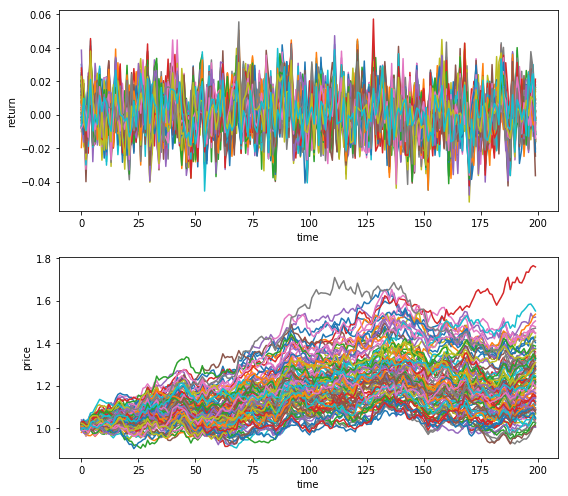

In [7]:
G.print_ret()

We study the spectrum of the empirical sample estimate of correlation, compare it to the spectrum of the true correlation matrix and explore various eigenvalues cleaning techniques.

According to the Marcenko-Pastur law, the spectrum of the sample estimator for a set of $N$ variables with $T$ observations tends to a continuum of values between $(1±\sqrt{q})^2$ where $q$ is the limit observation ratio $\frac{N}{T}<=1$.
For other correlation matrix, the spectrum of the sample estimator typically consists of a dense bulk region of eigenvalues and a large, isolated eigenvalue.

This result gives rise to a number of cleaning heuristics where low eigenvalues are attributed to noise in the sample and are thus discarded/adjusted

## Sample correlation

The sample estimator typically produces a noisy spectrum that has both lower and higher values in the bulk than the true correlation matrix. This can be verified in both the histogram of sample eigenvalues and in the distribution of eigenvalues decay (the sample eigenvalues curve typically starts higher and terminated lower than the true eigenvalues curve).

Estimation error: 6.312843833243183


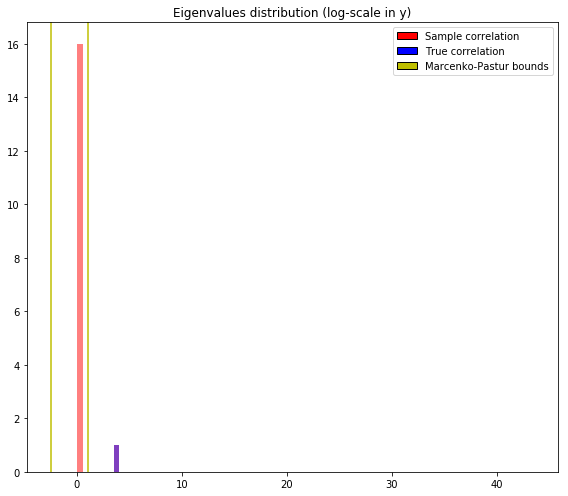

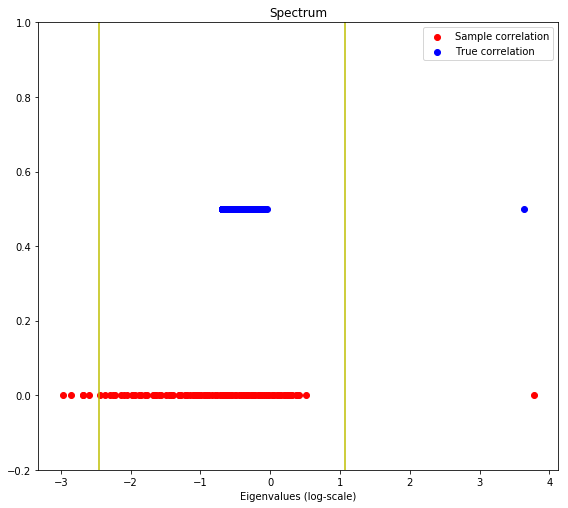

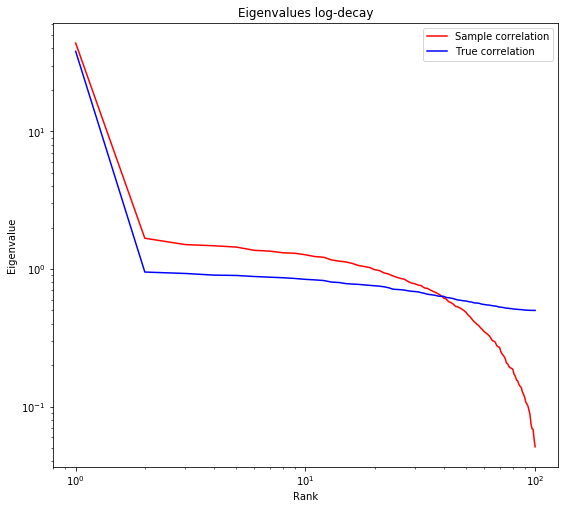

In [8]:
print('Estimation error: {}'.format(G.estimate_error()))
G.plot_eig(log_hist=LOG_HIST)

## Linear shrinkage

A standard, basic technique to clean the sample spectrum is to shrink the estimator towards the identity matrix. This translates as a right shift of the sample spectrum, thus pushing up the low, noisy eigenvalues.

In [9]:
class LinearShrinkageCorrReturn(ReturnGenerator):
    def __init__(self, corr_matrix, std_dev, T, mean_rets = None, shrinkage=0):
        super().__init__(corr_matrix, std_dev, T, mean_rets)
        self._estimation_mode = 'Linear shrinkage correlation'
        self._shrinkage = shrinkage
        
    def corr_estimate(self):
        """
        Linear shrinkage estimate, returns (1-shrinkage)*E+shrinkage*Id,
        where E is the sample estimate
        """
        return (1-self._shrinkage)*np.matmul(self._normalized_rets.T, self._normalized_rets)/self._T + self._shrinkage*np.eye(self._N)

Estimation error: 19.369335932972984


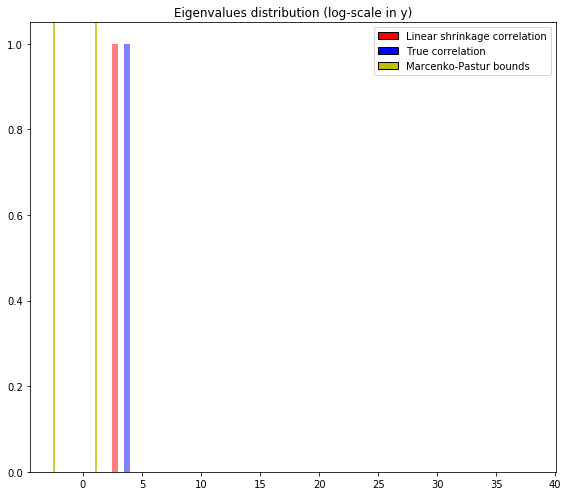

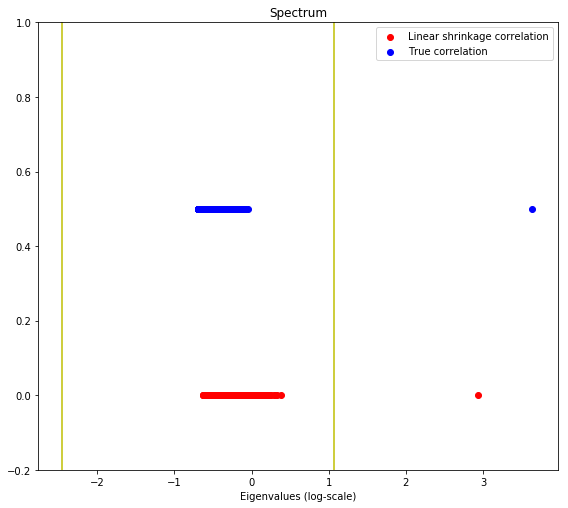

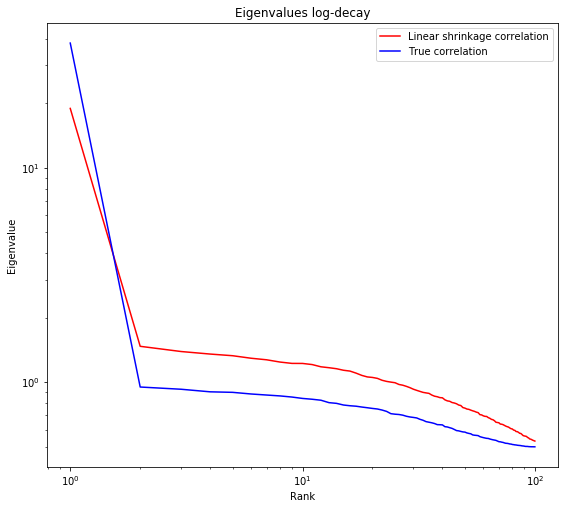

In [10]:
G_linear_shrinkage = LinearShrinkageCorrReturn(corr_matrix, std_dev, T, mean_rets = mean_rets, shrinkage=0.5)
print('Estimation error: {}'.format(G_linear_shrinkage.estimate_error()))
G_linear_shrinkage.plot_eig(log_hist=LOG_HIST)

## Eigenvalues clipping

The following technique interprets all eigenvalues below the upper Marcenko-Pastur bound as noisy eigenvalues. They are replaced with a constant eigenvalues, calibrated so that the trace of the sample correlation matrix (i.e the sum of eigenvalues, which is equal to $N$) remains unchanged.

In [11]:
class EigenClippingCorrReturn(ReturnGenerator):
    def __init__(self, corr_matrix, std_dev, T, mean_rets = None, alpha=0):
        super().__init__(corr_matrix, std_dev, T, mean_rets)
        self._estimation_mode = 'Eigenvalues clipping correlation'
        # fraction of sample eigenvalues to keep 
        self._alpha = alpha
        self._N_alpha = None
        self._gamma = None
        
    def corr_estimate(self):
        """
        Returns the matrix with same top ceil(N*alpha) eigenvalues as sample estimate,
        floors the remaining one so that trace remains unchanged
        """
        # in 'MP+' mode, keep only eigenvalues above the upper Marcenko-Pastur bound
        if self._alpha == 'MP+':
            self._N_alpha = int(sum(self._sample_eigenvalues>=self._lambda_plus))
        else:
            self._N_alpha = int(np.ceil(self._N*self._alpha))
            
        # remember : trace(sample_corr)=N because all diagonal entries of sample_corr are 1s
        self._gamma = (self._N-np.sum(self._sample_eigenvalues[:self._N_alpha]))/(self._N-self._N_alpha)
        
        # ok to concatenate like this since self._sample_eigenvalues are natively sorted in descending order
        new_eigenvalues = np.concatenate((self._sample_eigenvalues[:self._N_alpha], [self._gamma]*(self._N-self._N_alpha)))
        return np.matmul(self._sample_eigenvectors, np.matmul(np.diag(new_eigenvalues), self._sample_eigenvectors.T))

Estimation error: 2.905707820998561


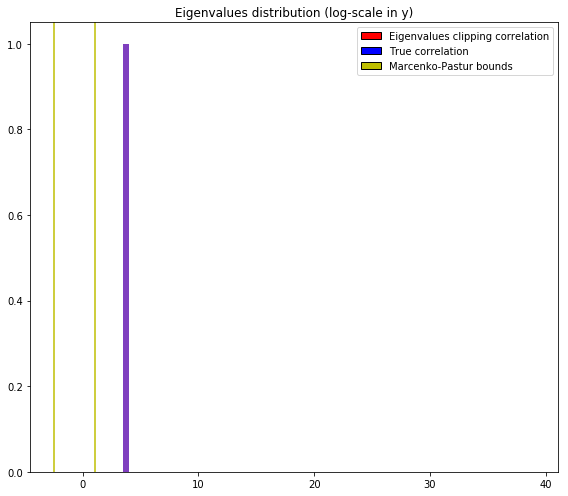

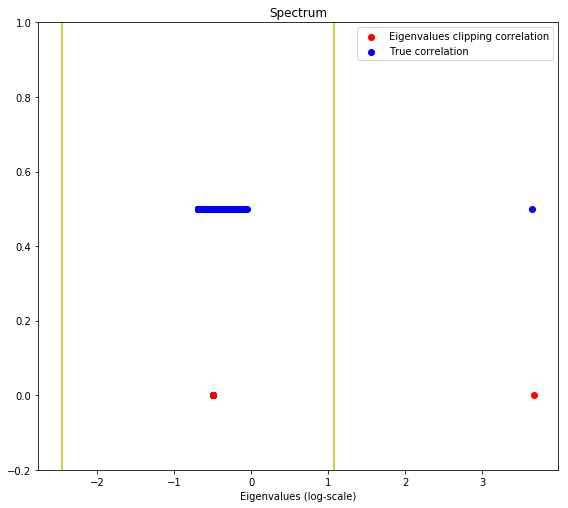

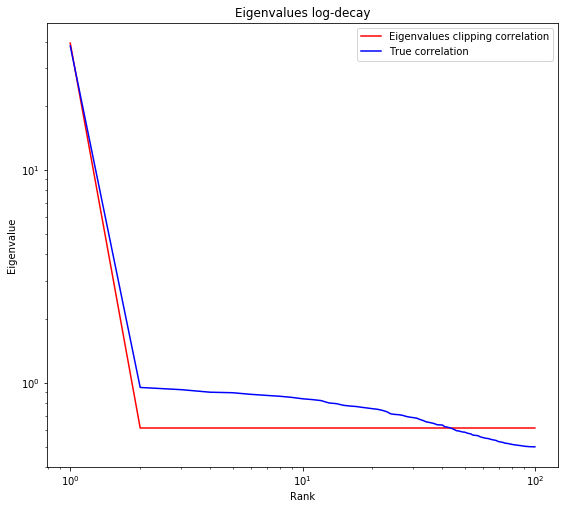

In [12]:
G_eigen_clipping = EigenClippingCorrReturn(corr_matrix, std_dev, T, mean_rets = mean_rets, alpha='MP+')
print('Estimation error: {}'.format(G_eigen_clipping.estimate_error()))
G_eigen_clipping.plot_eig(log_hist=LOG_HIST)

A smoother technique based on the same heuristics is to keep only the top $\alpha$ eigenvalues, and shift the remaining ones to a constant, once again calibrated to the sample trace. This allows to control the degree of cleaning thanks to the hyperparameter $\alpha$ (using the Marcenko-Pastur has a hard limit can lead to shifting all but the highest eigenvalues, thus potentially loosing a lot of useful information in the process)

Estimation error: 2.681180274860644


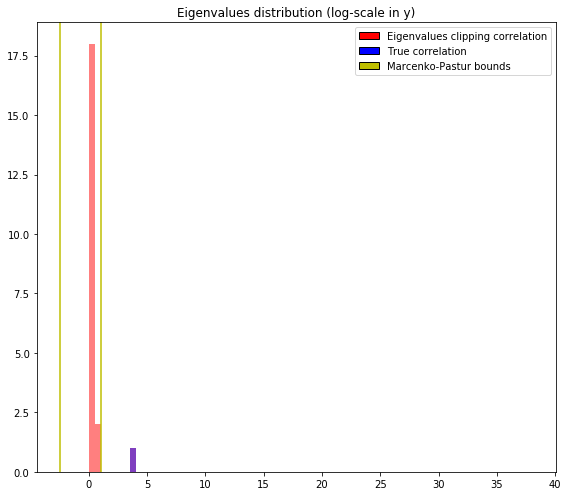

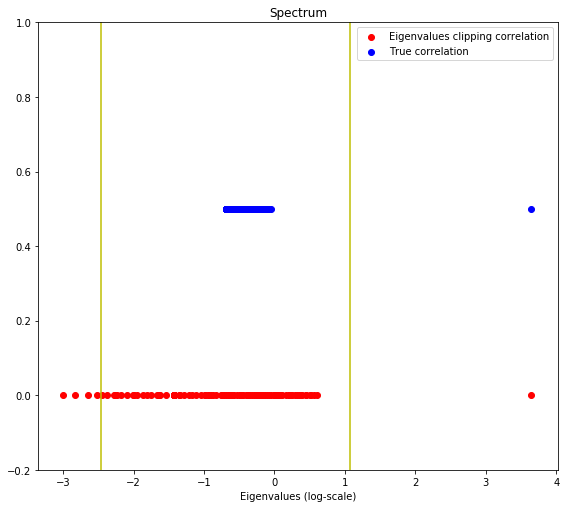

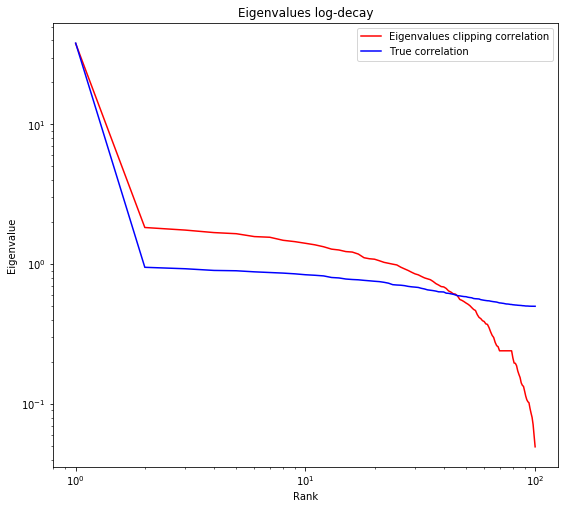

In [13]:
G_eigen_clipping = EigenClippingCorrReturn(corr_matrix, std_dev, T, mean_rets = mean_rets, alpha=0.9)
print('Estimation error: {}'.format(G_eigen_clipping.estimate_error()))
G_eigen_clipping.plot_eig(log_hist=LOG_HIST)